## Recupération des news


In [159]:
!pip install wordcloud
!pip install nltk
!pip install yfinance
!pip install plotly
!pip install pandas_datareader

In [203]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


# Partie wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import urllib


# Partie NLP
import nltk

nltk.download('punkt')
words = nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re

# Partie DataViz
import math

import yfinance as yf
import datetime 

import plotly.graph_objects as go

# Partie modelisation/optmisation

from numpy import matrix, array, zeros, empty, sqrt, ones, dot, append, mean, cov, transpose, linspace

from numpy.linalg import inv, pinv

import pandas_datareader as pdr
from datetime import datetime
from pylab import *

import plotly.express as px

import scipy.optimize
import random

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [163]:
def get_company():

    """
    On récupère une liste contenant le noms des différentes entreprises du Investing.com United state 30
    return = liste de mots
    """
    
    url = 'https://fr.investing.com/indices/investing.com-us-500-components'
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    tbody = soup.findAll("td",{"class":"bold left noWrap elp plusIconTd"})
    l = []
    for p in tbody:
        l.append(p.find("a")['href'].split('/')[2])
    return l

In [164]:
liste_entreprise = get_company()
#liste_entreprise

In [165]:
def get_news(company,nb_page=1):
    """
    Cette fonction permet de récupérer les titres des news associés à une compagnie sur une page donnée
    
    entrée : 
    company = le nom de l'entreprise dont on souhaite obtenir les news (format = chaine de caractère). Elle doit correspondre à une page d'investing.com
    nb_page = numero de la page sur lesquels on souhaite retourner les news (1 page = 10 titres) (format = int)
    
    sortie:
    retourne une liste de titre de news
    """

    url = 'https://www.investing.com/equities/'+company+'-news/'+str(nb_page)
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    article_body = soup.findAll("a",{"class":"title"})
    #print(article_body)
    l=[]
    for p in article_body:
        l.append(p.get("title"))
    return l[6:]

In [50]:
print(get_news("tesla-motors",3))

['Tesla recalls some model 3 and model S vehicles in China', "The Year of the Doge? 2021, crypto's wildest year yet", 'MicroStrategy Increased Its Bitcoin Holdings Once More', 'Lucid Stock Jumps After Citi Calls It a Buy, With 48% Potential Upside', 'Shiba Inu (SHIB) Plans Big Surprises for 2022', 'Micron, Tesla, Biogen Fall Premarket; Johnson & Johnson Rises', 'Tesla Trades Weaker on Recall of Certain Model 3 and S Cars', '2021: The Year in Review', 'Dow, S&P close at record highs as Omicron worries ease', "Tesla's Musk exercises all of his stock options expiring next year", 'Should you use a trading bot? The good, the bad, and the ugly of algorithmic trading.', 'Alvexo - Trading CFDs with Candlesticks', 'Alvexo - Non-Farm Payroll Report (NFP): Live Trading Event', 'Alvexo - Getting Started with Technical Analysis']


In [51]:
def get_tilte_dictionary(company_list, number_page=1):
    """
    Cette fonction permet de créer un dictionnaire en associant chaque companie avec ces news
    
    entrée : 
    company_list = liste des noms d'entreprises dont on souhaite obtenir les news
    nb_page = nombre de pages sur lesquels on souhaite itérer
    
    sortie:
    dictionnaire : clé = companie
                   valeur = texte contenant tout les titres
    """

    dicto = {}
    for company in company_list :
        l = []
        for page in range(1,number_page+1):
            l = l + get_news(company, page)
        dicto[str(company)] = ' '.join(l).lower()
    
    return dicto


## Word cloud version simple

Peut-être essayer de faire un truc qui cherche le masque automatiquement à partir du nom de l'entreprise si on le sent

In [56]:
data = get_tilte_dictionary(liste_entreprise[:100],1)

In [57]:
print(data['boeing-co'])

pre-market movers: tesla jumps, ford, boeing rise; ross stores dips jet maker safran plans 12,000 hires in 2022 as air traffic recovers israel signs deal to buy $3.1 billion in u.s. helicopters, tankers u.s. stocks mixed at close of trade; dow jones industrial average up 0.25% boeing 737 max to resume flights in indonesia – report s&p 500 ends lower after four-day rally to record high u.s. stocks mixed at close of trade; dow jones industrial average up 0.26% s&p 500 snaps record run after briefly topping 4,800 s&p 500 eases from record as tech stumble offsets rebound in travel stocks stocks making the biggest moves midday: coinbase, boeing, carnival and more should you use a trading bot? the good, the bad, and the ugly of algorithmic trading. alvexo - trading cfds with candlesticks alvexo - non-farm payroll report (nfp): live trading event alvexo - getting started with technical analysis


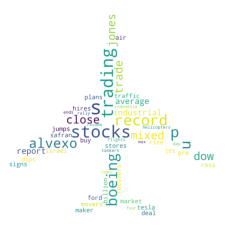

In [58]:
mask = np.array(Image.open(requests.get('https://www.freeiconspng.com/uploads/airplane-icon-image-gallery-1.png', stream=True).raw))

wordcloud = WordCloud(background_color = 'white', max_words = 50, mask  = mask).generate(data['boeing-co'])
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# NLP

## Fonction qui transforme les données d'un seul coup:

In [59]:
def clean_text(text):
    """
    Cette fonction permet de nettoyer les textes pour pouvoir les traiter et les analyser
    
    entrée : 
    texte = texte brut contenant les titres des news associés à une compagnie
    
    sortie:
    texte = texte modifié 
    """
    
    words = nltk.word_tokenize(text)
    
    words = [word for word in words if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    keep_words = ['up', 'down', 'under','no'] #modifier cette liste ????
    stop_words = [word for word in stop_words if word not in keep_words]
    words = [ word for word in words if not word in stop_words]
    
    stemmer = SnowballStemmer(language = 'english')
    stemmed = [stemmer.stem(word) for word in words]
    
    return(' '.join(stemmed))

In [60]:
def return_sentiment(company_data):
    """
    Cette fonction permet de retourner l'analyse de sentiment à une compagnie donnée.
    
    entrée : 
    company_data = texte de titre de news associé à une companie
    
    sortie:
    texte = score d'analyse de sentiment avec des poids de 1.5 aux mots à connotation positive, 1 aux mots neutres et -1.5 pour les mots à connotation négatives. Ces poids ont étés choisi arbitrairement donc discutable.
    """
    
    text = clean_text(company_data)
    sid = SentimentIntensityAnalyzer()
    l = sid.polarity_scores(clean_text(company_data))
    return(l['pos']*1.5 + l['neu'] - l['neg']*1.5) #fonction faites à la main,à discuter

In [61]:
def build_data_sentiment(company_list, page=1):
    """
    Cette fonction permet de compiler toutes les fonctions précedemment définis. A partir d'une liste de compagnie, cette fonction retourne un dataframe avec deux colonnes les companies associés à leur score d'analyse de sentiment
    
    entrée : 
    company_list = liste des noms d'entreprises dont on souhaite obtenir les news
    nb_page = nombre de pages sur lesquels on souhaite itérer
    
    sortie:
    df = dataframe avec une colonne des compagnie et une colonne de score d'analyse de sentiment
    """
    data = get_tilte_dictionary(company_list, page)
    df = pd.DataFrame(columns = ['company','score'])
    for company in company_list : 
        df = df.append({'company': str(company), 'score':return_sentiment(data[company])},ignore_index=True)
    return df

In [62]:
df = build_data_sentiment(liste_entreprise,3) #surment un peu long pour le dataframe complet !!!

In [63]:
df = df.set_index('company')
ordered_df = df['score'].sort_values(ascending = False)

In [64]:
kept_company = ordered_df[:20]
print(kept_company)

company
signet-jewelers-limited     1.0240
cboe-holdings-inc           0.9690
hershey-co                  0.9675
pepsico                     0.9670
zions-bancorp               0.9665
nike                        0.9650
motorola-inc                0.9630
zoetis-inc                  0.9620
metlife-inc                 0.9585
waste-managemnt             0.9575
kohls-corp                  0.9550
eqt-corporation             0.9545
polo-ralph-laur             0.9540
kroger-co                   0.9525
eastman-chem                0.9520
essex-property-trust-inc    0.9515
pnc-fin-serv                0.9510
eaton                       0.9495
intuitive-surgical-inc      0.9495
te-connectivity             0.9465
Name: score, dtype: float64


In [166]:
def get_tickers(company):
    """
    cette fonction retourne le ticker d'une entreprise à partir de son sur investing
    
    entrée:
    company : string contenant le nom de l'entreprise sur investing
    
    sortie:
    ticker :  string contenant le ticker correspondant
    """
    url = 'https://www.investing.com/equities/'+company
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    article_body = soup.findAll("h1",{"class":"text-2xl font-semibold instrument-header_title__GTWDv mobile:mb-2"})
    #print(article_body)
    ticker = str(re.search(r'\((.*?)\)',str(article_body)).group(0) )
    ticker = re.search(r'[a-zA-Z]+',ticker ).group(0) 
    return ticker

In [167]:
def get_ticker_list(kept_company):
    l=[]
    for i in range(len(kept_company)):
        l.append(get_tickers(kept_company.index[i]))
    return l

In [168]:
#get_ticker_list(kept_company)

In [169]:
tickers = get_ticker_list(kept_company)

In [170]:
def retrieve_ticker_name(tickers):
    l = []
    for i in tickers:
        stock = yf.Ticker(i)
        if stock.info['longName'] == None:
            l.append(i)
        else:
            l.append(stock.info['longName'])
    return(l)

ticker_name = retrieve_ticker_name(tickers)

In [171]:
def load_data(tickers, start = datetime.datetime(2012,5,31), end = datetime.datetime.now() ):
    df = yf.download(tickers, start, end,group_by="ticker") 
    #print(df)
    return(df)
    
data = load_data(tickers)

[*********************100%***********************]  20 of 20 completed


In [172]:
def keep_close(tickers, data):
    sortie = pd.DataFrame()
    for i in tickers:
        Close = data[i]["Adj Close"]
        sortie[i] = Close
    return sortie

data_close = keep_close(tickers, data)

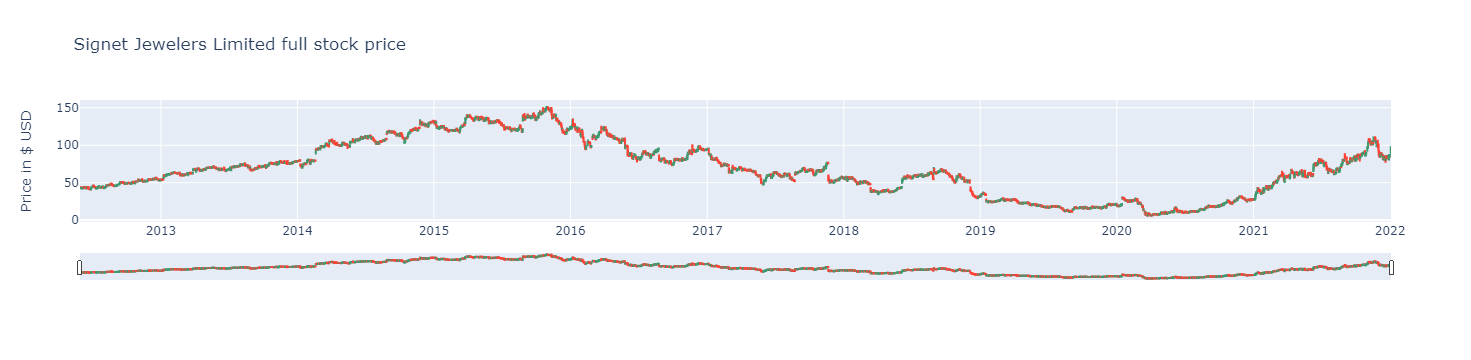

In [173]:
df = data[tickers[0]]

fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)])

fig.update_layout(
    title=ticker_name[0]+' full stock price',
    yaxis_title="Price in $ USD")

fig.show()

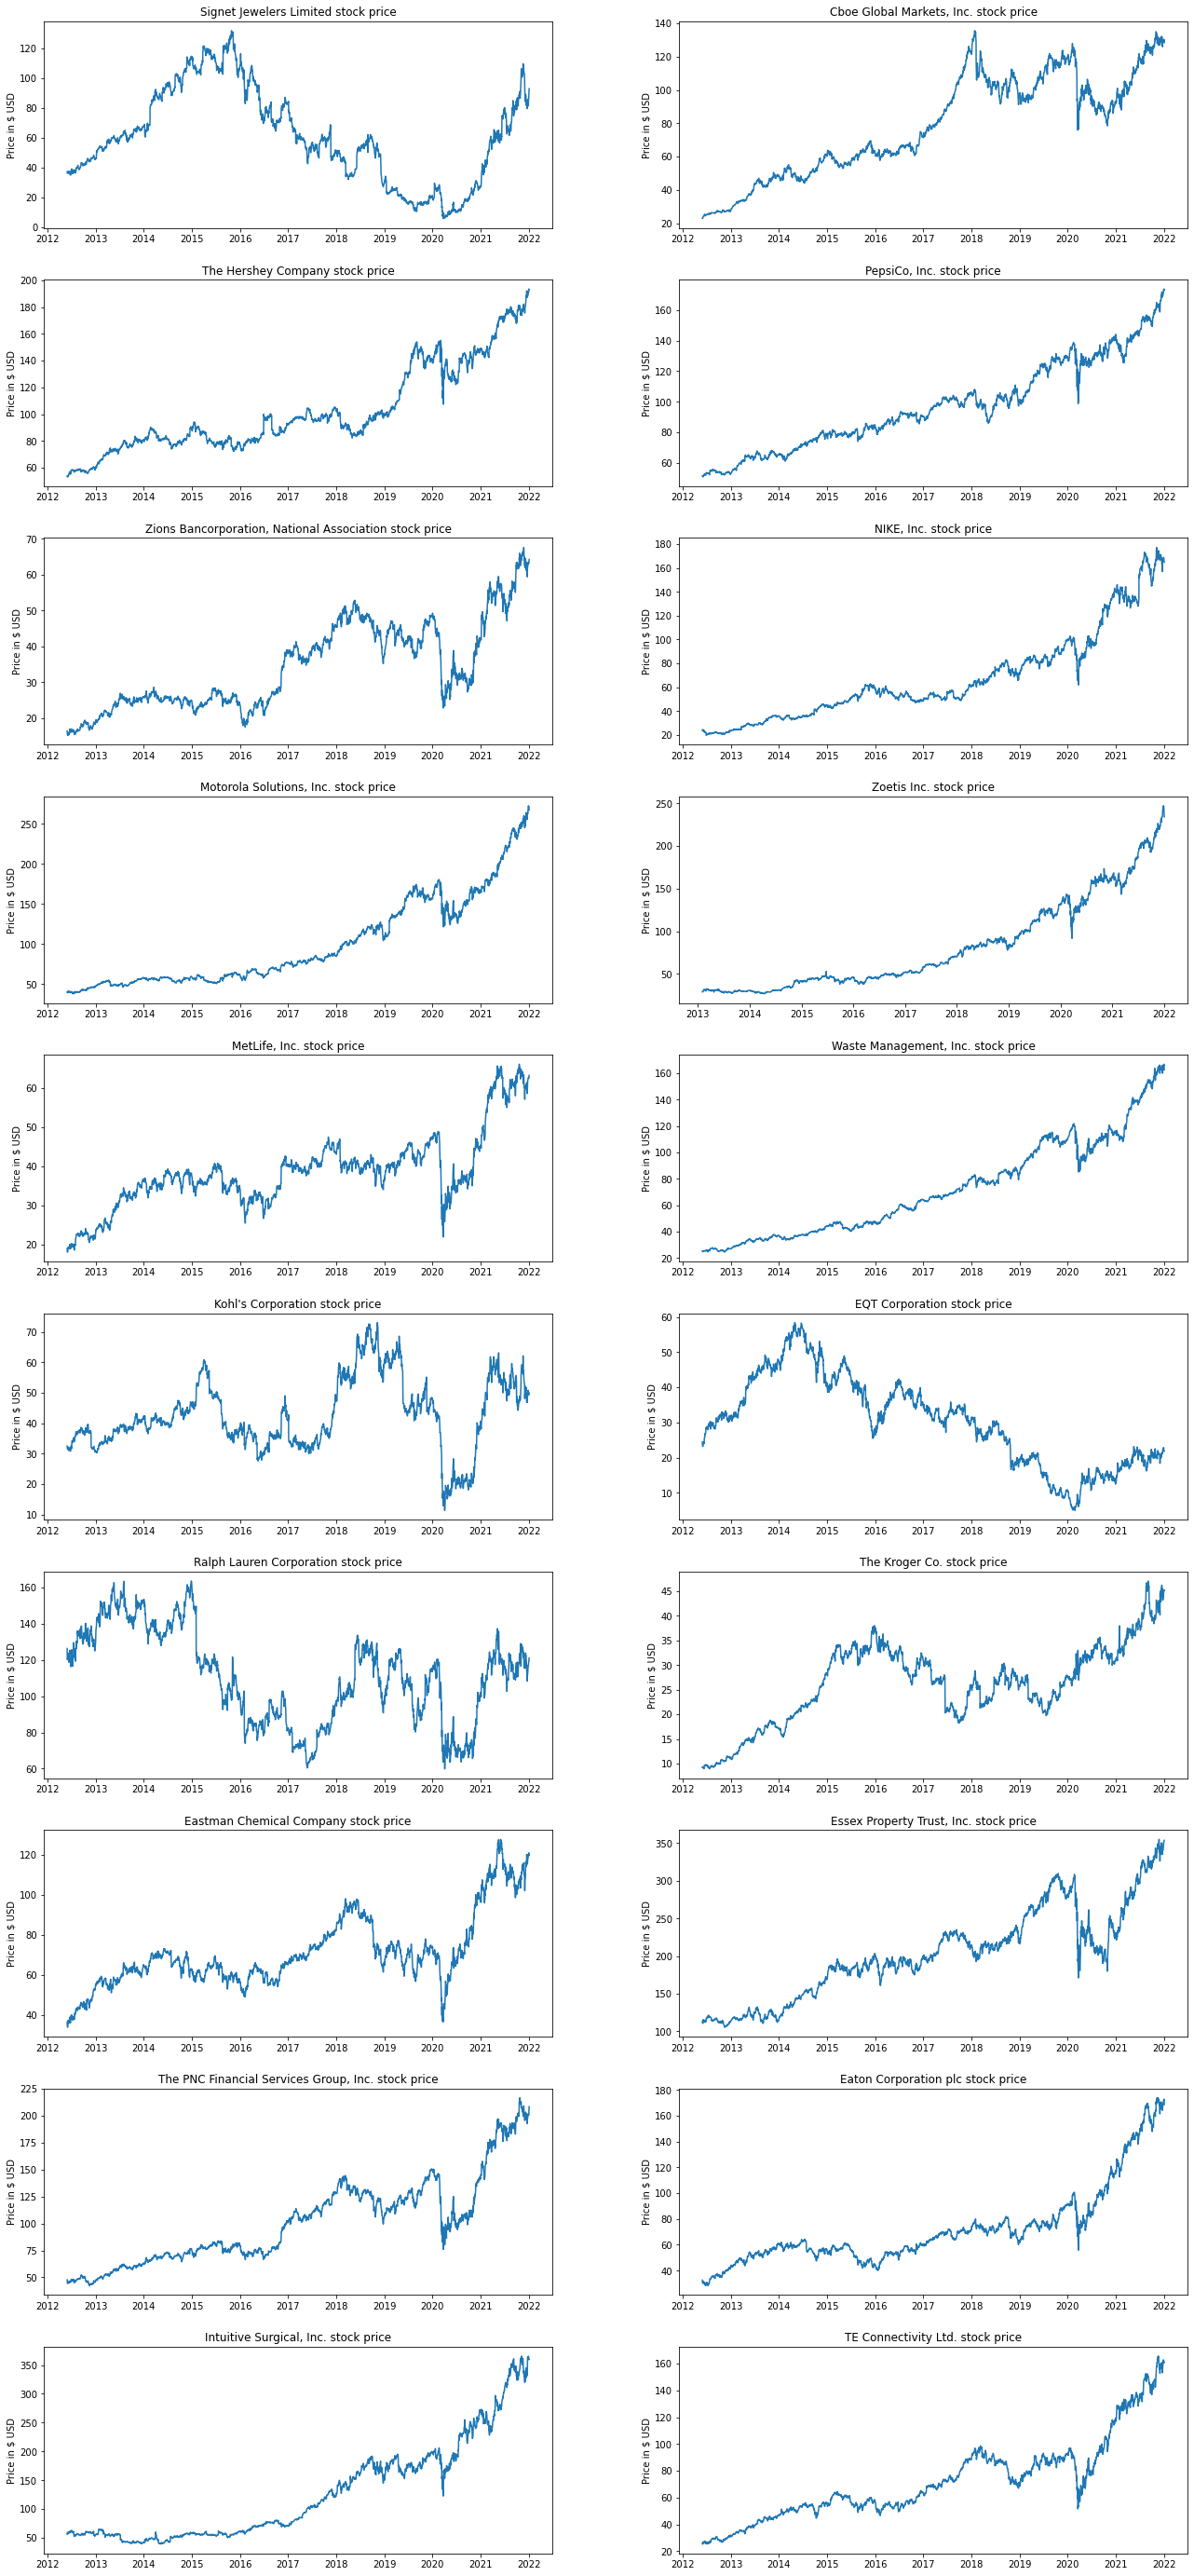

In [174]:
fig = plt.figure(figsize=(22, 50))
rows = 10
columns =2
grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)
for i in range(rows*columns):
    exec (f"plt.subplot(grid{[i]})")
    plt.plot(data_close[tickers[i]])
    plt.title(ticker_name[i] +" stock price")
    plt.ylabel("Price in $ USD")

In [105]:
data_log_close = data_close.apply(np.log, axis=1)
data_return = data_log_close - data_log_close.shift(1)
data_return = data_return.iloc[1: , :]
corr = data_return.corr()
corr.style.background_gradient(cmap='coolwarm')

,SIG,CBOE,HSY,PEP,ZION,NKE,MSI,ZTS,MET,WM,KSS,EQT,RL,KR,EMN,ESS,PNC,ETN,ISRG,TEL
SIG,1.000000,0.271808,0.225912,0.212240,0.407543,0.319980,0.293403,0.220890,0.423262,0.300173,0.474198,0.248643,0.388545,0.126329,0.402691,0.300925,0.446599,0.415550,0.220331,0.434455
CBOE,0.271808,1.000000,0.354665,0.367920,0.314442,0.295176,0.314929,0.303931,0.352197,0.386668,0.214715,0.092177,0.214737,0.111161,0.268609,0.353414,0.405675,0.316573,0.250990,0.351379
HSY,0.225912,0.354665,1.000000,0.588930,0.200046,0.308422,0.339231,0.339546,0.304201,0.490335,0.171394,0.145279,0.184052,0.197967,0.296436,0.428154,0.345030,0.351759,0.283115,0.359124
PEP,0.212240,0.367920,0.588930,1.000000,0.266656,0.391858,0.422668,0.428199,0.423039,0.552145,0.205484,0.156547,0.272545,0.242751,0.344299,0.483077,0.405580,0.433312,0.341014,0.407550
ZION,0.407543,0.314442,0.200046,0.266656,1.000000,0.380504,0.391614,0.268710,0.749881,0.379814,0.463930,0.295663,0.492659,0.136848,0.598418,0.347132,0.811206,0.574846,0.286711,0.542237
NKE,0.319980,0.295176,0.308422,0.391858,0.380504,1.000000,0.404141,0.416398,0.459466,0.416288,0.346111,0.180730,0.443351,0.162224,0.411156,0.358678,0.452212,0.469219,0.373124,0.482668
MSI,0.293403,0.314929,0.339231,0.422668,0.391614,0.404141,1.000000,0.444616,0.464275,0.487043,0.299479,0.167215,0.350878,0.183407,0.438484,0.394369,0.472815,0.486407,0.398313,0.463090
ZTS,0.220890,0.303931,0.339546,0.428199,0.268710,0.416398,0.444616,1.000000,0.402170,0.437410,0.208467,0.182798,0.255075,0.132077,0.353978,0.357778,0.395427,0.442774,0.460256,0.460191
MET,0.423262,0.352197,0.304201,0.423039,0.749881,0.459466,0.464275,0.402170,1.000000,0.471287,0.464363,0.302790,0.517839,0.180827,0.658424,0.403469,0.788204,0.664354,0.390835,0.625908
WM,0.300173,0.386668,0.490335,0.552145,0.379814,0.416288,0.487043,0.437410,0.471287,1.000000,0.287196,0.175476,0.334389,0.186723,0.417787,0.497678,0.511130,0.509253,0.347137,0.469696


# Partie Modélisation/Optimisation du portefeuille

In [150]:
def calcul_meanvar(names, prices, caps): #données entrée = noms action, prix de cloture (pas les return, on les recalcul dans la fonction), et le market cap
        prices.dropna(axis=0,inplace=True)
        
        ####################################################
        
        #j'ai changé le price en transposant la matrice en sa transposé pour que cela marche lors de mes tests. cela aura peut-être un impact sur la suite, à verifier
        
        ####################################################
        
        prices = matrix(prices).transpose()                     #matrice des prix
        weights = array(caps) / sum(caps)       # matrice des poids
        
        # matrice des rendements historiques
        rows, cols = prices.shape
        returns = empty([rows, cols-1])
        for r in range(rows):
                for c in range(cols-1):
                        p0, p1 = prices[r,c], prices[r,c+1]
                        returns[r,c] = (p1/p0)-1

        # calcul des rendements moyens
        returns_exp = array([])
        for r in range(rows):
                returns_exp = append(returns_exp, np.mean(returns[r]))
        # calcul des covariances
        covars = cov(returns)

        returns_exp = (1+returns_exp)**250-1      # on annualise les rendements
        covars = covars * 250                           # on annualise les covariances

        return names, weights, returns_exp, covars

#       rf (ou r)       taux sans risque (fixé arbitrairement)
#       C               matrice variance covariance  = covars
#       W               poids des actifs = weigth
#       R               rendements des actifs = returns_exp


In [183]:
from pandas_datareader import data
def temporary_market_cap(tickers): #fonction à la va vite pour tester le code et bien comprendre ce que renvoie la fonction précédente, en faire une plus propre pour le rendu final
    return list(data.get_quote_yahoo(tickers)['marketCap'])

In [129]:
def mean_ptf(W, R):    #calcul du rendement moyen du portefeuille
    return sum(R*W)


In [130]:
def var_ptf(W, C):     #calcul de la variance du portefeuille
    return np.dot(np.dot(W, C), W)

In [131]:
def fit_model(W, R, C, r=0.2):
    # pour un niveau donné de rendement, on calcule le portefeuille qui minimise la variance
    mean = mean_ptf(W, R)
    var = var_ptf(W, C)
    penalty = 50*abs(mean-r)
    return var + penalty 

In [132]:
def mean_ptf_var(W,R,C):
    return mean_ptf(W,R), var_ptf(W,C)

In [133]:
# Fonction qui construit la frontière efficiente de markowitz (ensemble des portefeuilles efficients
def build_frontier(R, C, rf= 0.2): #je mets 0.2 par defaut pour tester
    frontier_mean, frontier_var, frontier_weights = [], [], []
    n = len(R)      
    for r in linspace(min(R), max(R), num=20): 
        W = ones([n])/n # matrice initialisé des poids (poids équilibré entre tous les actifs au départs)               
        b_ = [(0,1) for i in range(n)]
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }) # on restreint les poids à 100% du portefeuille
        optimized = scipy.optimize.minimize(fit_model, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_) # algo de minimisation
        #print(optimized)
        if not optimized.success:
            raise BaseException("bug opti")
        frontier_mean.append(r)                                                 
        frontier_var.append(var_ptf(optimized.x, C))
        frontier_weights.append(optimized.x)
    return array(frontier_mean), array(frontier_var), frontier_weights


In [134]:
#calcul du portefeuille optimal au sens de markowitz
def build_weights(R, C, rf):
        def fit_model(W, R, C, rf):
                mean, var = mean_ptf_var(W, R, C)      
                util = (mean - rf) / sqrt(var)         
                return 1/util                                       
        n = len(R)
        W = ones([n])/n     # matrice initialisée des poids (poids équilibrés entre tous les actifs au départs)               
        b_ = [(0.,1.) for i in range(n)]
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })       # on restreint les poids à 100% du portefeuille
        optimized = scipy.optimize.minimize(fit_model, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
                raise Exception("bug opti")
        return optimized.x

In [152]:
def ptf_optim(title, names, R, C, rf, color='green'):
        # optimisation du portefeuille
        W = build_weights(R, C, rf) 
        mean, var = mean_ptf_var(W, R, C)                                      
        f_mean, f_var, f_weights = build_frontier(R, C, rf)        

        # on affiche le point de variance minimale
        print(title)
        print_assets(names, W, R, C)
        n = len(names)
        scatter([C[i,i]**.5 for i in range(n)], R, marker='x',color=color)
        for i in range(n):                                                                       
                text(C[i,i]**.5, R[i], '  %s'%names[i], verticalalignment='center', color=color)
        scatter(var**.5, mean, marker='o', color=color)             
        plot(f_var**.5, f_mean, color=color)             
        xlabel('$\sigma$'), ylabel('$r$')
        plt.grid(True)

Infos actifs poids historique
Nom         Poids Rendements    Std    Correlations
Signet Jewelers Limited   0.4%  26.5%  60.3%    1.000 
Cboe Global Markets, Inc.   1.1%  20.8%  24.5%    0.259 1.000 
The Hershey Company   3.1%  15.4%  21.0%    0.205 0.346 1.000 
PepsiCo, Inc.  18.7%  15.3%  18.1%    0.198 0.363 0.591 1.000 
Zions Bancorporation, National Association   0.8%  19.3%  32.3%    0.410 0.311 0.192 0.258 1.000 
NIKE, Inc.  20.5%  28.2%  26.1%    0.321 0.293 0.318 0.399 0.381 1.000 
Motorola Solutions, Inc.   3.6%  24.4%  24.0%    0.287 0.313 0.340 0.425 0.389 0.410 1.000 
Zoetis Inc.   9.0%  30.5%  24.5%    0.211 0.300 0.336 0.426 0.263 0.412 0.443 1.000 
MetLife, Inc.   4.1%  15.9%  30.5%    0.423 0.350 0.298 0.420 0.754 0.471 0.466 0.400 1.000 
Waste Management, Inc.   5.4%  23.5%  18.0%    0.288 0.388 0.496 0.560 0.379 0.428 0.496 0.434 0.472 1.000 
Kohl's Corporation   0.5%  17.0%  47.5%    0.470 0.210 0.166 0.199 0.477 0.350 0.302 0.206 0.480 0.285 1.000 
EQT Corporation 

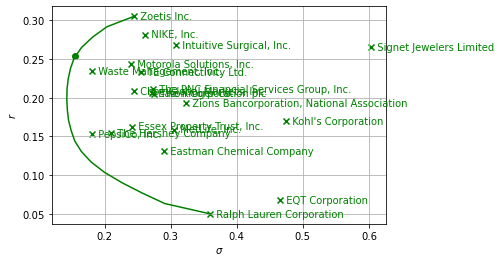

In [156]:
#### APPLICATION DE L'ENSEMBLE DES FONCTIONS PRECEDENTES POUR UNE ETUDE DE CAS
names, prices, caps = ticker_name, data_close, temporary_market_cap(tickers)
n = len(names) #chargement des données

# on calcule les rendements attendus et les covariances de nos actifs
names, W, R, C = calcul_meanvar(names, prices, caps)
rf = .025 #rendement actif sans risque

def print_assets(names, W, R, C):
        print("%-10s %6s %6s %6s %s" % ("Nom", "Poids", "Rendements", "Std", "   Correlations"))
        for i in range(len(names)):
                print("%-10s %5.1f%% %5.1f%% %5.1f%%    " % (names[i], 100*W[i], 100*R[i], 100*C[i,i]**.5), end='')
                for j in range(i+1):
                        corr = C[i,j] / (sqrt(C[i,i]) * (sqrt(C[j,j]))) # calcul des correlation à partir de la covariance
                        print("%.3f " % corr, end='')
                print()

print("Infos actifs poids historique")
print_assets(names, W, R, C)

# on calcule le rendement historique de notre portefeuille et sa variance
mean, var = mean_ptf_var(W, R, C)

# optimisation de notre portfeuille au sens de markowitz (maximise le ratio de sharpe) basé sur les prix historiques
ptf_optim("Optimisation au sens de Markowitz", names, R, C, rf, color='green')
show()

L'idée de cette première partie c'est d’arriver à trouver et de construire des index qui ne sont pas disponible gratuitement. On a choisi de reproduire les poids des industries dans le S&P500 à partir de la taxonomie des GICS (crée par Standard & Poor’s).

- Dans un premier temps on utilise le site 'https://slickcharts.com/sp500' pour prendre les tickers de S&P500 et grâce à une library de Yahoo finance recuperer chaque Capitalisation Boursière des chaque 505 entreprises du S&P500
- Dans un deuxième temps on arrive à calculer les poids de chaque entreprise dans le S&P500 grâce à une division du MarketCap de chaque entreprise sur le MarketCap total de chaque entreprise.

In [205]:
def geteGics(tickers):

    industryGics = []

    for tick in tickers:
        # rotation de ticker par page web
        url = 'https://eresearch.fidelity.com/eresearch/evaluate/snapshot.jhtml?symbols='+tick
        page = requests.get(url, verify=False)
        # Trouver a acceder a l'endroit precis dans la page. 
        soup = BeautifulSoup(page.content, 'html.parser')
        table = soup.find('div',{'id': 'companyProfile'})
        table = table.find_all('div',{'class': 'sub-heading'})[1]
        table = table.text.replace('\n','').replace('Industry (GICS®)','')
    

        industryGics.append(table.replace('.','/'))

    return industryGics

In [207]:
Industry_names=geteGics(tickers)

In [185]:
weights = temporary_market_cap(tickers)
weights = array(weights) / sum(weights)

In [189]:
# Creation d'un DataFrame
d = {'Ticker': tickers,'Weight': weights, 'Industry':Industry_names}
df = pd.DataFrame(d)
# Les deux sites utilisent des formats de texte differents, surtout pour le and et & mais aussi majuscule et miniscule
# Donc on format tout de la meme maniere
df['Industry']=df['Industry'].str.replace('and', '&').str.title()
df.reset_index(drop=True, inplace = True)
df.head(10)

,Ticker,Weight,Industry
0,SIG,0.003830,Specialty Retail
1,CBOE,0.010718,Capital Markets
2,HSY,0.031140,Food Products
3,PEP,0.187118,Beverages
4,ZION,0.007864,Banks
5,NKE,0.203917,"Textiles, Apparel & Luxury Goods"
6,MSI,0.035338,Communications Equipment
7,ZTS,0.086628,Pharmaceuticals
8,MET,0.041611,Insurance
9,WM,0.053261,Commercial Services & Supplies


In [191]:
def extract_content(url):
    
    # Fonction d'extraction des données de la page
    page = requests.get(url, verify=False)
    soup = BeautifulSoup(page.content,'html.parser')
    content = soup.prettify()
    return content

In [204]:
def parse_content():
    
    # Fonction qui recupere toute la table Wikipédia avec le nom du sous secteur et son code.
    content = extract_content('https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard')
    content = content.split('wikitable')[1]
    content = content.replace('/','')
    content = content.replace('\n','')
    content = content.replace('amp;','')
    content = content.replace('<td>','<td>/')
    lines = content.split('<tr>')
    

    tout = ''
    for i in lines[2:] : 
        text = i.split('<td>')
        for j in text :
            j = re.sub('<[^>]+>', '', j)
            tout += j
    tout=re.sub(' +',' ',tout)
    tout = tout.replace('/ /','/')
    tout = tout.split('Revision')[0]
    tout = tout.strip()
    tout = tout.split('/')

    liste_code = []
    liste_int = []

    for i in range(0, len(tout)-1,2):
        liste_code.append(tout[i].strip())
        liste_int.append(tout[i+1].strip())

    manpage = pd.DataFrame()
    manpage['code'] = liste_code
    manpage['intitule'] = liste_int
    manpage['intitule'] = manpage['intitule'].str.replace('and','&').str.title()

    return manpage

mainpage = parse_content()

In [193]:
mainpage.head()

,code,intitule
0,10,Energy
1,1010,Energy
2,101010,Energy Equipment & Services
3,10101010,Oil & Gas Drilling
4,10101020,Oil & Gas Equipment & Services


In [194]:
def get_ind(sub_ind):
    
    # Fonction qui arrive a detecter pour chaque ticker toutes les types d'industrie et/ou sous industrie qui fait partie

    possible = mainpage[mainpage['intitule'] == sub_ind]['code'].tolist()
    ind = ''
    ind_gr = ''
    sector = ''
    
    if len(possible)>0:

        code = possible[len(possible)==8]
        ind = mainpage[mainpage['code'] == code[:6]]['intitule'].tolist()[0]
        ind_gr = mainpage[mainpage['code'] == code[:4]]['intitule'].tolist()[0]
        sector = mainpage[mainpage['code'] == code[:2]]['intitule'].tolist()[0]

    return (ind,ind_gr,sector)

In [195]:
# Creation des nouvelles colonne dans le dataframe initial
df['Industry'] = df['Industry'].map(lambda x: get_ind(x)[0])
df['Industry_Group'] = df['Industry'].map(lambda x: get_ind(x)[1])
df['Sector'] = df['Industry'].map(lambda x: get_ind(x)[2])

In [196]:
df = df[['Ticker','Weight','Industry_Group']]
df['Weight'] = df['Weight'].astype(str).astype('float64')
df.head()

,Ticker,Weight,Industry_Group
0,SIG,0.003830,Retailing
1,CBOE,0.010718,Diversified Financials
2,HSY,0.031140,"Food, Beverage & Tobacco"
3,PEP,0.187118,"Food, Beverage & Tobacco"
4,ZION,0.007864,Banks


In [197]:
byindus = df.groupby(['Industry_Group']).sum()
byindus

,Weight
Industry_Group,
Banks,0.076713
Capital Goods,0.052597
Commercial & Professional Services,0.053261
Consumer Durables & Apparel,0.210882
Diversified Financials,0.010718
Energy,0.006452
Food & Staples Retailing,0.025995
"Food, Beverage & Tobacco",0.218258
Health Care Equipment & Services,0.100616


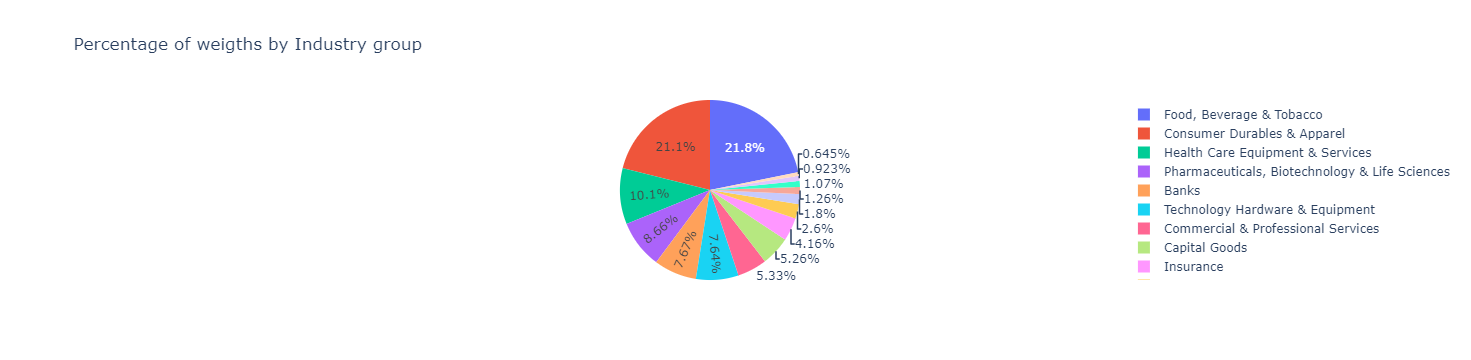

In [198]:
fig = px.pie(byindus, values='Weight', names=byindus.index, title='Percentage of weigths by Industry group')
fig.show()

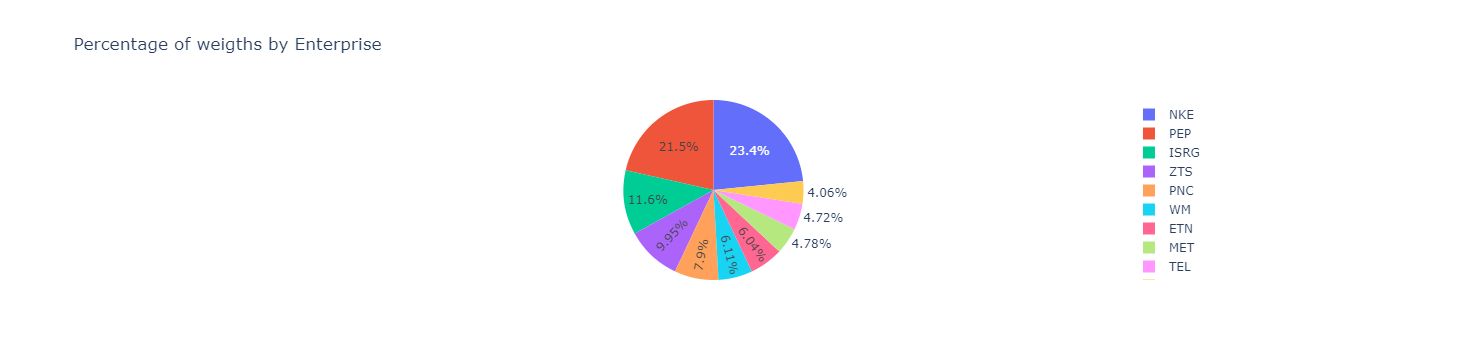

In [199]:
##### on a trié les poids des actifs dans l'ordre décroissant et on a choisi ne que 10 premières
df_top_10=df.sort_values(by=['Weight'], ascending=False).iloc[:10,]
fig2 = px.pie(df_top_10, values='Weight', names='Ticker', title='Percentage of weigths by Enterprise')
fig2.show()

In [200]:
df_top_10

,Ticker,Weight,Industry_Group
5,NKE,0.203917,Consumer Durables & Apparel
3,PEP,0.187118,"Food, Beverage & Tobacco"
18,ISRG,0.100616,Health Care Equipment & Services
7,ZTS,0.086628,"Pharmaceuticals, Biotechnology & Life Sciences"
16,PNC,0.068850,Banks
9,WM,0.053261,Commercial & Professional Services
17,ETN,0.052597,Capital Goods
8,MET,0.041611,Insurance
19,TEL,0.041103,Technology Hardware & Equipment
6,MSI,0.035338,Technology Hardware & Equipment


In [201]:
verification = byindus['Weight'].sum()
if verification > 0.9999:
    print("C'est bon")
else:
    print("C'est la merde")
    
# ca doit faire 1 (ou presque)

C'est bon
